# Housing Prices Prediction

### Ben Branchflower
This is my submission to the [Housing Price Prediction Kaggle competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).  
  
The data is described in detail [here](https://ww2.amstat.org/publications/jse/v19n3/Decock/DataDocumentation.txt). This was the justification for most of the replacing of values that I did.

I used some other people's ideas for cleaning the data and features to create. To give credit where it is due I will link to their kernels. 
#### Data Processing
[Stacked Regressions : Top 4% on LeaderBoard](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard) Author: Serigne  
[Exploratory Data Analysis of Housing in Ames, Iowa](https://www.kaggle.com/leeclemmer/exploratory-data-analysis-of-housing-in-ames-iowa) Author: Lee Clemmer

#### Feature Engineering
[House prices: Lasso, XGBoost, and a detailed EDA](https://www.kaggle.com/erikbruin/house-prices-lasso-xgboost-and-a-detailed-eda) Author: Erik Bruin  

## Imports
These things will get used at different periods throughout the code but I don't want to get lost in what has and has not been imported so I will do it all up here

In [1]:
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error as mse
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from scipy.special import boxcox1p
import xgboost

%matplotlib inline

## Preliminary Data Analysis
Kaggle made it easy to get the data form a simple download as csv files. I will read them in with pandas and take a quick look at what we have.

In [2]:
train = pd.read_csv('house_train.csv')
train_id = train.Id
train.drop(columns=['Id'], inplace=True) # we don't need this id variable
y = train['SalePrice'] # saving the house prices separately
print('train shape:', train.shape) 
test = pd.read_csv('house_test.csv')
test_id = test.Id # we need this for the submission
test.drop(columns=['Id'], inplace=True)
print('test shape:', test.shape)
train.head()

train shape: (1460, 80)
test shape: (1459, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Just from this preliminary glance we can see that there are plenty of missing values we will want to deal with. Some summary statistics will help us to get a little bit better feel for them and we will look closer at them with plots.

In [3]:
train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


## Target Variable
Let's look at the variable we are predicting to better understand what we are looking at. I will make some histograms and plot their deviation from a normal distribution. It will make our lives easier if we are predicting on a distribution that we undertsand.

Text(0.5,1,'Transformed QQ-plot')

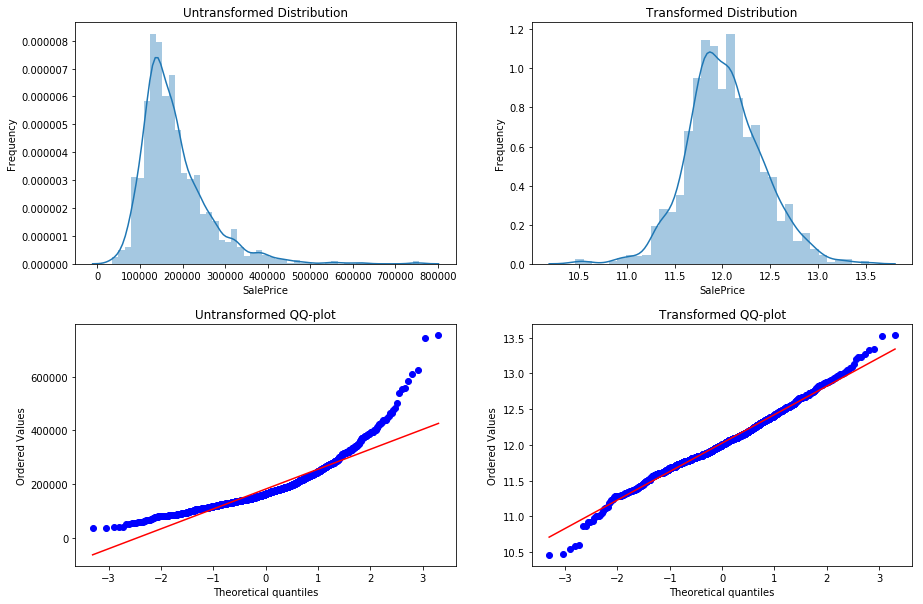

In [4]:
fig = plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
sns.distplot(y)
plt.ylabel("Frequency")
plt.title('Untransformed Distribution')
plt.subplot(2,2,2)
sns.distplot(np.log(y))
plt.ylabel("Frequency")
plt.title('Transformed Distribution')
plt.subplot(2,2,3)
res = stats.probplot(y, plot=plt)
plt.title('Untransformed QQ-plot')
plt.subplot(2,2,4)
res = stats.probplot(np.log(y), plot=plt)
plt.subplots_adjust(hspace=0.25)
plt.title('Transformed QQ-plot')

From this we can see that a log transform gives us a much nicer distribution in the target variable so we will work with that and the untransform our model results at the end so we are working with the actual values when we submit. There are likely things we need to work on in the feature variables as well to get them working as best they can.

# Features

## Analysis of current features
Now that we have a better undertsanding of what is happening with the values that we are trying to predict, let's look at the variables we are using to predict.  

### Outliers  
The most obvious outliers are in the GrLivArea variable. I will display the plots to show you why we should remove them.

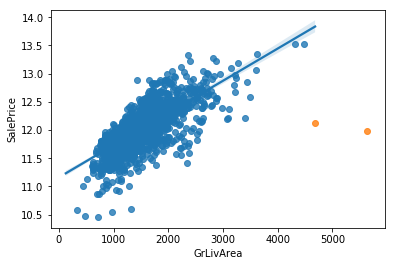

In [5]:
sns.regplot(train['GrLivArea'][train['GrLivArea'] < 4500], np.log(y[train['GrLivArea'] < 4500]))
sns.regplot(train['GrLivArea'][train['GrLivArea'] > 4500], np.log(y[train['GrLivArea'] > 4500]),
           fit_reg=False)

The values we see marked in orange are clear outliers due to there large level in this variable and they do not represent the increase in value shown by the rest of the data. We will just drop those from our data because they will likely end up hurting our predictions.  
The documentation recommends dropping all of the values of GrLivArea over 4000 but the two closest to that cutoff seem to fit the trend so I will keep those ones as they aren't hurting our prediction.

In [6]:
y = y[train.GrLivArea < 4500] # that is a cutoff that removes the bad ones we saw above
train = train[train.GrLivArea < 4500]

## Exploring Features

In [7]:
# This is a function to separate the categorical variables from numerics so I can work with them differently
def get_feature_groups(df):
    """Returns lists of numerical and categorical features"""
    # Numerical Features
    num_features = df.select_dtypes(include=['int64','float64']).columns

    # Categorical Features
    cat_features = train.select_dtypes(include=['object']).columns
    return list(num_features), list(cat_features)
num_features, cat_features = get_feature_groups(train.drop(columns=['SalePrice']))

#### Numeric Variables
Let's use some correlation plots to see how the features are related

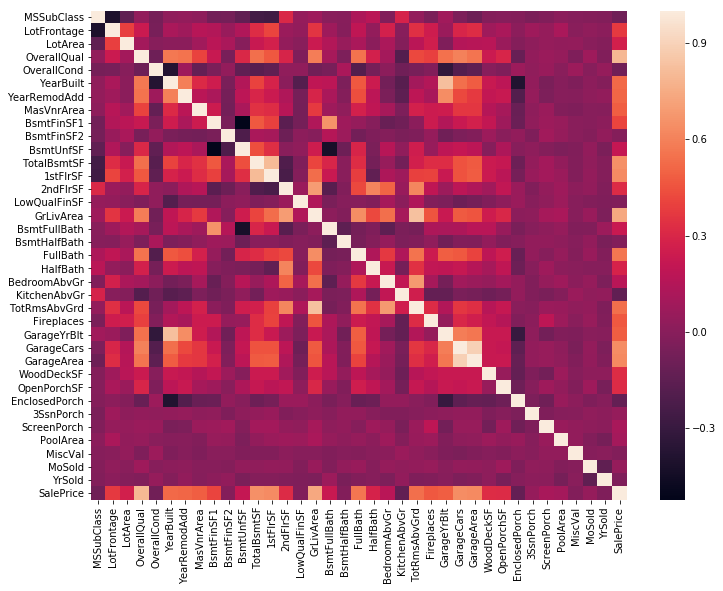

In [8]:
plt.subplots(figsize=(12,9))
sns.heatmap(train.corr())

We seem to have some pretty strong correlations between some of the variables but the colinearity doesn't hurt our predictions so we can leave everything in there.  
We can also get an idea of what variables are most important if we look at the correlation between the numeric variables and sale price.

In [9]:
print(np.absolute(train.corr()['SalePrice']).sort_values(ascending=False)[1:10])

OverallQual     0.795774
GrLivArea       0.734968
TotalBsmtSF     0.651153
GarageCars      0.641047
1stFlrSF        0.631530
GarageArea      0.629217
FullBath        0.562165
TotRmsAbvGrd    0.537769
YearBuilt       0.523608
Name: SalePrice, dtype: float64


Those are some pretty good correlations at the top so that is a good sign that we can get some good predictions.

## Classification Adjustments
The fact that a variable has numbers doesn't necessarily mean that it should be treated as a running variable. I will adjust the variables accordingly based on the documentation, some suggestions of the kernels linked to under data processing and my own opinion. I don't think that the step form Poor to Fair is the same as the step form Good to Excellent so I would say that many of these variables would be better as categoricals. A similar principle applies ot Gravel versus pavement driveways so that should help more as a categorical variable.

In [11]:
for df in [train, test]:
    # Alley
    df.Alley.replace({1:'Grvl', 2:'Pave'}, inplace=True)

    # Lot Shape
    df.LotShape.replace({1:'Reg', 2:'IR1', 3:'IR2', 4:'IR3'}, inplace=True)

    # Land Contour
    df.LandContour.replace({1:'Low', 2:'HLS', 3:'Bnk', 4:'Lvl'}, inplace=True)

    # Utilities
    df.Utilities.replace({1:'ELO', 2:'NoSeWa', 3:'NoSewr', 4:'AllPub'}, inplace=True)

    # Land Slope
    df.LandSlope.replace({1:'Sev', 2:'Mod', 3:'Gtl'}, inplace=True)

    # Basement Quality
    df.BsmtQual.replace({1:'Po', 2:'Fa', 3:'TA', 4:'Gd', 5:'Ex'}, inplace=True)

    # Basement Condition
    df.BsmtCond.replace({1:'Po', 2:'Fa', 3:'TA', 4:'Gd', 5:'Ex'}, inplace=True)

    # Basement Exposure
    df.BsmtExposure.replace({1:'No', 2:'Mn', 3:'Av', 4:'Gd'}, inplace=True)

    # Finished Basement 1 Rating
    df.BsmtFinType1.replace({1:'Unf', 2:'LwQ', 3:'Rec', 4:'BLQ', 5:'ALQ', 6:'GLQ'}, inplace=True)

    # Finished Basement 2 Rating
    df.BsmtFinType2.replace({1:'Unf', 2:'LwQ', 3:'Rec', 4:'BLQ', 5:'ALQ', 6:'GLQ'}, inplace=True)

    # Fireplace Quality
    df.FireplaceQu.replace({1:'Po', 2:'Fa', 3:'TA', 4:'Gd', 5:'Ex'}, inplace=True)

    # Garage Finish
    df.GarageFinish.replace({1:'Unf', 2:'RFn', 3:'Fin'}, inplace=True)

    # Garage Quality
    df.GarageQual.replace({1:'Po', 2:'Fa', 3:'TA', 4:'Gd', 5:'Ex'}, inplace=True)

    # Garage Condition
    df.GarageCond.replace({1:'Po', 2:'Fa', 3:'TA', 4:'Gd', 5:'Ex'}, inplace=True)

    # Paved Driveway
    df.PavedDrive.replace({1:'N', 2:'P', 3:'Y'}, inplace=True)

    # Pool Quality
    df.PoolQC.replace({2:'Fa', 3:'TA', 4:'Gd', 5:'Ex'}, inplace=True)

# we don't want sale price with the features anymore so I will drop it
train.drop(columns=['SalePrice'], inplace=True)
# Get a list of numerical and categorical features from the function defined earlier
num_features, cat_features = get_feature_groups(df=train)

## Missing Data
Some of the values are missing and need to be replaced so I will do that next.

In [12]:
for c in train.columns:
    if train[c].isnull().any():
        print(f'{c}: Missing {train[c].isnull().sum()}')

LotFrontage: Missing 259
Alley: Missing 1367
MasVnrType: Missing 8
MasVnrArea: Missing 8
BsmtQual: Missing 37
BsmtCond: Missing 37
BsmtExposure: Missing 38
BsmtFinType1: Missing 37
BsmtFinType2: Missing 38
Electrical: Missing 1
FireplaceQu: Missing 690
GarageType: Missing 81
GarageYrBlt: Missing 81
GarageFinish: Missing 81
GarageQual: Missing 81
GarageCond: Missing 81
PoolQC: Missing 1452
Fence: Missing 1177
MiscFeature: Missing 1404


In a lot of cases the missing value just means that the home does not have the given feature so we will fill in missing values with 'None' there. Some of them make more sense to have a 0 filled in as opposed to 'None' as they are numeric. In the case where we don't have a lot of missing values I will assume that the houses are whatever occurs the most in that variable.

In [13]:
for df in [train, test]:
    # fill in frontage with median of neighborhood type
    df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
    # fill in the missing data here with the most common value
    df['MSZoning'].fillna(df['MSZoning'].mode()[0])
    # making lists of things ot do the same thing to
    nones = ['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','GarageType','GarageFinish','GarageQual',
             'GarageCond','BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
             'BsmtFinType2', 'MasVnrType', 'MSSubClass']
    zeroes = ['GarageYrBlt','GarageArea','GarageCars','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
              'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']
    modes = ['Electrical', 'Exterior1st', 'Exterior2nd', 'SaleType']
        
    # iterating to change the missing valeus in each column
    for col in nones:
        df[col].fillna('None', inplace=True)
    for col in zeroes:
        df[col].fillna(0, inplace=True)
    for col in modes:
        df.fillna(df[col].mode()[0], inplace=True)
        
    # replacing functional missing values with Typ
    df['Functional'].fillna("Typ", inplace=True)

## Feature Engineering
We should create a few variables that aren't in there yet but are likely important. Square footage and number of bathrooms are split up into categories but the total is likely important. A remodel is also important and I would say that it effectively changes the age of the house. Also, a house sold new is likely going to be different from other houses as the seller is usually different enough that I would say it is important. We also need a certain amount of variation in the values of a variable for it to add predictive power so I will drop the Utilities feature as there is not enough for it to benefit us.

In [14]:
for df in [train, test]:
    # all of them are the same in the test set so we can just drop this feature
    df.drop(['Utilities'], axis=1, inplace=True)
    # making the total square feet variable
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    # total bathrooms
    df['TotBathroom'] =  df.FullBath + (df.HalfBath*0.5) + df.BsmtFullBath + (df.BsmtHalfBath*0.5)
    # remodeled variables
    df['Remodeled'] = [0 if x == True else 1 for x in df.YearBuilt == df.YearRemodAdd] #0=No Remodeling, 1=Remodeling
    df['AgeRemod'] = df['YrSold'].astype(int) - df['YearRemodAdd']
    # new houses are different from other houses
    df['SoldNew'] = [1 if x == True else 0 for x in df.YrSold == df.YearBuilt]
    # total porch square footage
    df['TotalPorchSF'] = df.OpenPorchSF + df.EnclosedPorch + df['3SsnPorch'] + df.ScreenPorch

## One More Adjustment
Now that we have all of our numeric variables, let's look at the distributions of the numerical variables and see if there are any problems we might be able to fix.

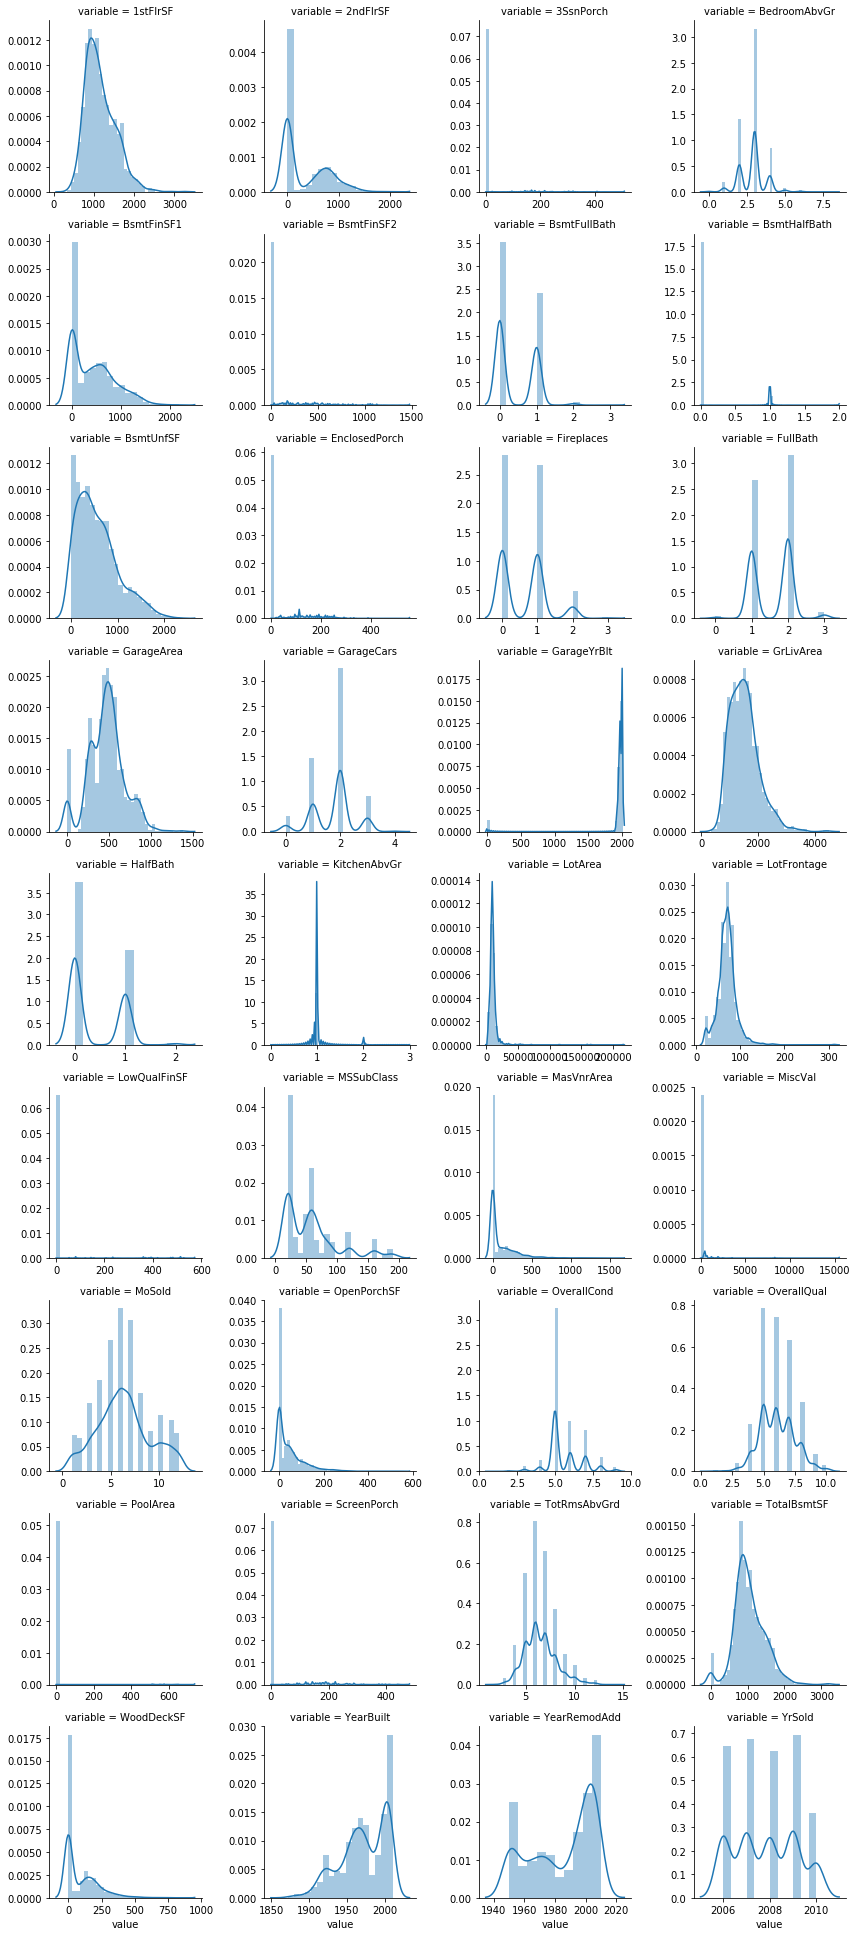

In [15]:
# Grid of distribution plots of all numerical features
f = pd.melt(train, value_vars=sorted(num_features))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.distplot, 'value')

We can see that there are quite a few variables that are skewed, much like the sale price that we transformed. It would be best to do the same for these as well. Let's look at how skewed they are and do a transform of the bad ones.

In [16]:
# calculate skew and show the 10 most skewed variables
skew = train[num_features].apply(lambda x:stats.skew(x.dropna())).sort_values(ascending=False)
print(skew[:10])

MiscVal          24.434913
PoolArea         15.932532
LotArea          12.560986
3SsnPorch        10.286510
LowQualFinSF      8.995688
KitchenAbvGr      4.480268
BsmtFinSF2        4.247550
ScreenPorch       4.114690
BsmtHalfBath      4.095895
EnclosedPorch     3.083987
dtype: float64


In [17]:
lam = 0.15
for df in [train, test]:
    for feat in skew.index[skew > 0.75]:
        df[feat] = boxcox1p(df[feat], lam)
# we don't need to see the plots again but here is the code if you want to see how they changed
# f = pd.melt(train, value_vars=sorted(num_features))
# g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
# g = g.map(sns.distplot, 'value')

We are almost ready for modelling. I will just convert the categorical variables to dummies

In [18]:
ntrain = train.shape[0] + 1
temp = train.append(test, sort=False)
temp = pd.get_dummies(temp)
train = temp[ntrain:]
test = temp[:ntrain]

In [19]:
print(train.shape)
print(test.shape)

(1458, 311)
(1459, 311)


It turns out these didn't improve my results very much but I have these variations of the data to try and squeeze out some better predictions.

In [20]:
# fit scaler
scaler = StandardScaler()
scaler.fit(train) #  fit  the scaler to the train set for later use
transformed = scaler.transform(train)

# some polynomial fits
poly = PolynomialFeatures(2)
train_poly = poly.fit_transform(train)
test_poly = poly.fit_transform(test)

# just interaction terms
inter = PolynomialFeatures(2, interaction_only=True)
train_inter = inter.fit_transform(train)
test_inter = inter.fit_transform(test)

# Modeling
Now that the data is ready to go, we will do the model fitting and evaluation. We can start off wiht a basic linear regression.

In [21]:
# preliminary result
reg = LinearRegression()
reg.fit(train, np.log(y))
print(np.sqrt(mse(np.log(y), reg.predict(train))))

0.3592185372538976


Lasso and Elastic Net should improve upon the baselin results from linear regression so we cna try those next

In [22]:
lasso = Lasso(alpha=0.001, random_state=1, max_iter=2500)
lasso.fit(train, np.log(y))
print(np.sqrt(mse(np.log(y), lasso.predict(train))))
# Result: 0.50590

0.37432536670193023


In [23]:
Enet = ElasticNet(alpha=0.001, l1_ratio=.9, random_state=1, max_iter=2000)
Enet.fit(train, np.log(y))
print(np.sqrt(mse(np.log(y), Enet.predict(train))))
# Result: 0.44449

0.373183420090678


Stochastic Gradient descent is another model that we could try.

In [24]:
SGD = SGDRegressor(max_iter=1000, alpha=0.0001, random_state=1)
SGD.fit(train, np.log(y))
print(mse(np.log(y), SGD.predict(train)))

4.546873907616633e+30


That is exciting! We are either predicting almost perfectly or we are overfitting a lot and it probably isn't the first one because prediction doesn't usually work that way.

KNearest Neighbor, XGBoost and Ridge are some other models that seemed fun and I wanted to try

In [25]:
KNR = KNeighborsRegressor(n_neighbors=25, weights='distance')
KNR.fit(transformed, np.log(y))
np.exp(KNR.predict(scaler.transform(test)))
# Result: 0.42058
KNR_2 = KNeighborsRegressor(n_neighbors=25, weights='distance')
KNR_2.fit(train, np.log(y))
np.exp(KNR_2.predict(test))
# Result: 0.42803

array([174492.23457291, 179716.97385332, 166980.70418705, ...,
       171608.47645298, 183669.7210024 , 160499.23397188])

In [26]:
xgb = xgboost.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
xgb.fit(train, np.log(y))
print(np.sqrt(mse(np.log(y), xgb.predict(train))))
# result: 0.47332

0.1377821728154036


In [27]:
ridge = Ridge(random_state=1)
ridge.fit(train, np.log(y))
np.sqrt(mse(np.log(y), ridge.predict(train)))

0.3608656863895132

## Submission

In [28]:
sub = pd.DataFrame()
sub['Id'] = test_id
sub['SalePrice'] = np.exp(ridge.predict(test))
sub.to_csv('submission.csv',index=False)

## Conclusion
So the K nearest Neighbour model turned out to be my best one with a score of 0.42058. Ranking me 3889 on the leaderboard.